In [11]:
import pandas as pd

df=pd.read_csv("input-2.csv")
df['class'] = df['class'].apply(lambda x: 1 if x=="human" else 0)
from sklearn.model_selection import train_test_split

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
from transformers import BertForSequenceClassification, BertTokenizer

In [13]:
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [14]:
import torch

def tokenize_and_encode(text, tokenizer, max_length):
    input_ids = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True, return_token_type_ids=False, return_attention_mask=True, return_tensors='pt')
    return input_ids['input_ids'], input_ids['attention_mask']

In [15]:
def get_dataloader(df, tokenizer, max_length, batch_size, shuffle=True):
    texts = df['text'].values
    labels = df['class'].values
    
    input_ids = []
    attention_masks = []
    
    for text in texts:
        input_id, attention_mask = tokenize_and_encode(text, tokenizer, max_length)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [16]:
def train_model(model, train_dataloader, optimizer, device):
    model.train()
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
    
    return model

In [17]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def evaluate_model(model, val_dataloader, device):
    model.eval()
    val_loss, val_accuracy = 0, 0
    n_val_steps = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch

            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
            val_accuracy += (preds == labels).float().mean().item()
            n_val_steps += 1

    val_loss /= n_val_steps
    val_accuracy /= n_val_steps

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    classification_rep = classification_report(all_labels, all_preds)

    return val_loss, val_accuracy, precision, recall, f1, classification_rep


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Epoch 1 Val Loss: 0.067, Val Accuracy: 0.973, Val Precision: 0.975, Val Recall: 0.973, Val F1: 0.974
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2126
           1       0.81      0.93      0.86       220

    accuracy                           0.97      2346
   macro avg       0.90      0.95      0.92      2346
weighted avg       0.98      0.97      0.97      2346

Epoch 2 Val Loss: 0.037, Val Accuracy: 0.988, Val Precision: 0.987, Val Recall: 0.988, Val F1: 0.987
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2126
           1       0.96      0.90      0.93       220

    accuracy                           0.99      2346
   macro avg       0.98      0.95      0.96      2346
weighted avg       0.99      0.99      0.99      2346

Epoch 3 Val Loss: 0.036, Val Accuracy: 0.990, Val Precision: 0.990, Val Recall: 0.990, Val F1: 0

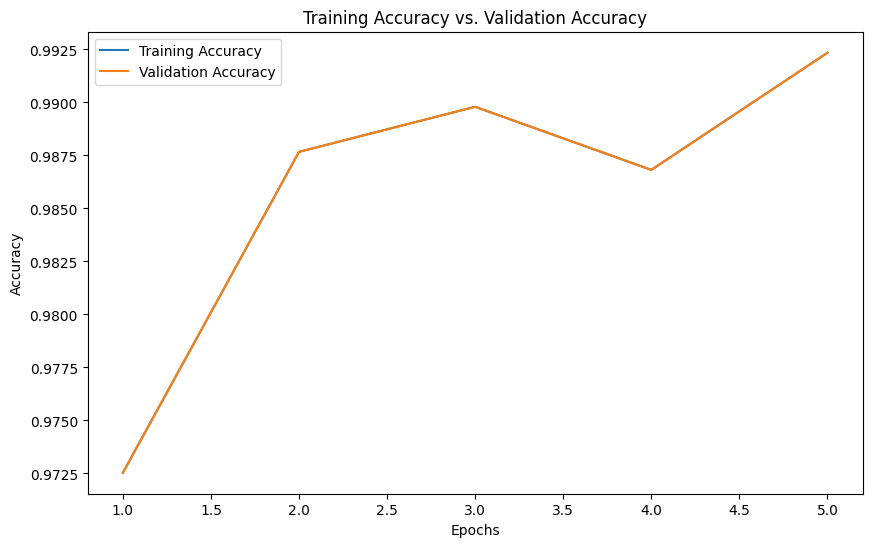

In [10]:


MAX_LENGTH = 128
BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

device = torch.device("cuda")
model = BertForSequenceClassification.from_pretrained("bert-base-cased").to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_dataloader = get_dataloader(train_df, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_dataloader = get_dataloader(test_df, tokenizer, MAX_LENGTH, BATCH_SIZE)

train_accuracies = []
val_accuracies = []
f1_scores = []

for epoch in range(NUM_EPOCHS):
    train_model(model, train_dataloader, optimizer, device)
    val_loss, val_accuracy, val_precision, val_recall, val_f1, classification_rep = evaluate_model(model, val_dataloader, device)
    train_accuracies.append(val_accuracy)  # Add validation accuracy for the epoch
    val_accuracies.append(val_accuracy)  # Add validation accuracy for the epoch
    f1_scores.append(val_f1)  # Add F1-score for the epoch
    print(f"Epoch {epoch + 1} Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}, Val Precision: {val_precision:.3f}, Val Recall: {val_recall:.3f}, Val F1: {val_f1:.3f}")
    print("Classification Report:\n", classification_rep)

# Plot the training accuracy vs. validation accuracy

plt.figure(figsize=(10, 6))
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs. Validation Accuracy')
plt.legend()
plt.show()

